In [36]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from collections import Counter, defaultdict
from itertools import product, combinations
import math
import cv2
from sklearn.model_selection import train_test_split

random.seed(42)

%matplotlib inline

In [37]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

In [41]:
IMAGE_SIZE = (70, 70)

def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # get the edges from the image
    edges = auto_canny(gray)
    #print(edges.shape)
    
    
    # assert(denoised != edges)
    # add the two images in a weighted manner
    weighted_sum = cv2.addWeighted(gray, 0.8, edges, 0.2, 0)
       
    return weighted_sum

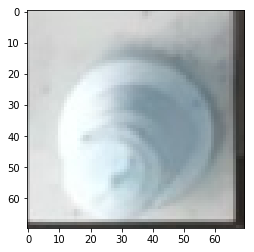

In [42]:
plt.imshow(cv2.imread("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images\\w\\f_4.jpg"), cmap='gray')

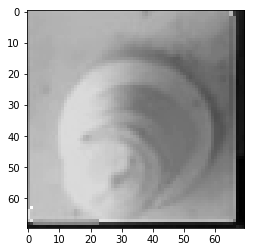

In [43]:
d = process_image("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\myboard_images\\w\\f_4.jpg")
plt.imshow(np.squeeze(d), cmap='gray')

In [44]:
d.shape

(70, 70)

In [45]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

In [46]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"):  

                    img_file_loc = os.path.join(piece_type_folder, f)
                    grayscale_image = process_image(img_file_loc)
                    grayscale_image = grayscale_image[..., np.newaxis]
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y)

In [47]:
X_train, y_train = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\Chess ID Public Data\\train")
X_test, y_test = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\Chess ID Public Data\\test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6899, 70, 70, 1)
(6899,)
(185, 70, 70, 1)
(185,)


In [48]:
from sklearn.metrics import confusion_matrix
from tensorflow import set_random_seed
set_random_seed(42)

In [49]:
# batch size
batch_size = 64

# number of training epochs
epochs = 150

required_input_shape = (*IMAGE_SIZE, 1)

In [50]:
model_folder_name = "models"
tensorboard_logs_folder_location = "logs"

In [51]:
def train_6_class_cnn_model(X_train, Y_train, X_test, Y_test):
    """"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()

    # checkpoint
    if not os.path.exists(model_folder_name):
        os.makedirs(model_folder_name)
    
    # tensorboard logs
    if not os.path.exists(tensorboard_logs_folder_location):
        os.makedirs(tensorboard_logs_folder_location)
    
    filepath = os.path.join(model_folder_name, "6_class_cnn.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, verbose=1, mode='max')
    
    tensorboard = TensorBoard(log_dir=tensorboard_logs_folder_location, histogram_freq=0, write_graph=True, write_images=True)
    
    callbacks_list = [checkpoint, earlystop, tensorboard]
    
    adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    hist = model.fit(X_train, Y_train, shuffle=True, batch_size=batch_size,
                     epochs=epochs, verbose=1,
                     validation_data=(X_test, Y_test), callbacks=callbacks_list)

    # Evaluating the model on the test data
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    return hist, model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 68, 68, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)        0         
__________

6899/6899 [==============================] - 2s 350us/step - loss: 1.2540 - acc: 0.5504 - val_loss: 1.0980 - val_acc: 0.6432: 0.54

Epoch 00021: val_acc did not improve from 0.64865
Epoch 22/150
6899/6899 [==============================] - 2s 350us/step - loss: 1.2393 - acc: 0.5567 - val_loss: 1.0903 - val_acc: 0.6541

Epoch 00022: val_acc improved from 0.64865 to 0.65405, saving model to models\6_class_cnn.hdf5
Epoch 23/150
6899/6899 [==============================] - 2s 349us/step - loss: 1.2404 - acc: 0.5649 - val_loss: 1.0887 - val_acc: 0.6595

Epoch 00023: val_acc improved from 0.65405 to 0.65946, saving model to models\6_class_cnn.hdf5
Epoch 24/150
6899/6899 [==============================] - 2s 349us/step - loss: 1.2340 - acc: 0.5569 - val_loss: 1.0935 - val_acc: 0.6432

Epoch 00024: val_acc did not improve from 0.65946
Epoch 25/150
6899/6899 [==============================] - 2s 349us/step - loss: 1.1910 - acc: 0.5695 - val_loss: 1.0956 - val_acc: 0.6432

Epoch 00025: val_acc d

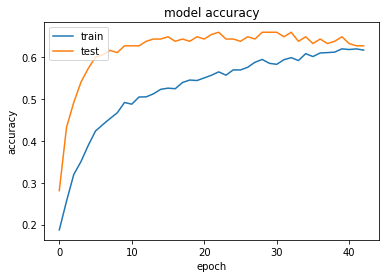

In [52]:
hist, model = train_6_class_cnn_model(X_train, y_train, X_test, y_test)

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[90  7  3  1  0  1]
 [ 4  5  5  1  0  0]
 [ 2  2  8  3  2  1]
 [ 2  6  8  0  2  0]
 [ 4  1  0  1  3  3]
 [ 3  1  1  2  3 10]]


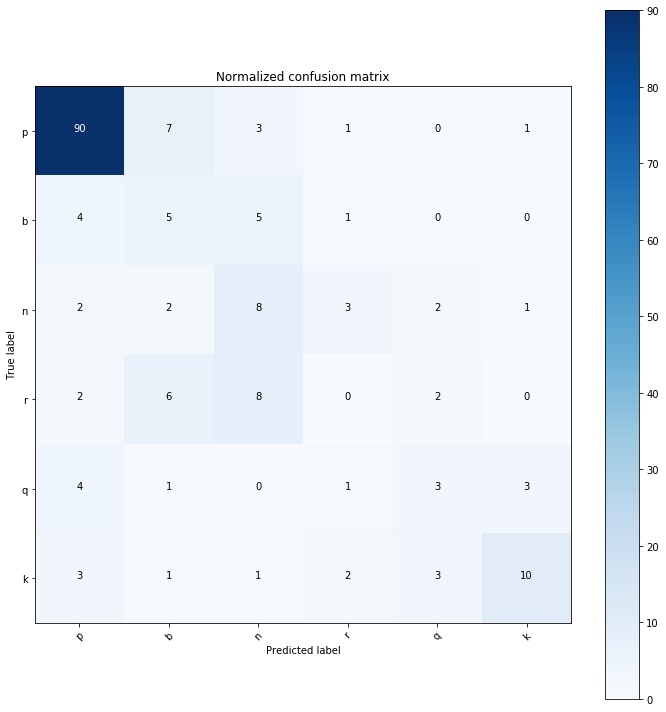

In [54]:
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["black", "white", "empty"]
test_predictions = model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=type_name_to_label, normalize=False,title='Normalized confusion matrix')

In [55]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values):
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    
    num_failed_images = len(mis_prediction_indices)
    num_images_per_row = IMAGES_PER_ROW
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)

    print(num_failed_images)
    print(num_rows)
    print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break

            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

(185, 70, 70)
69
14
5


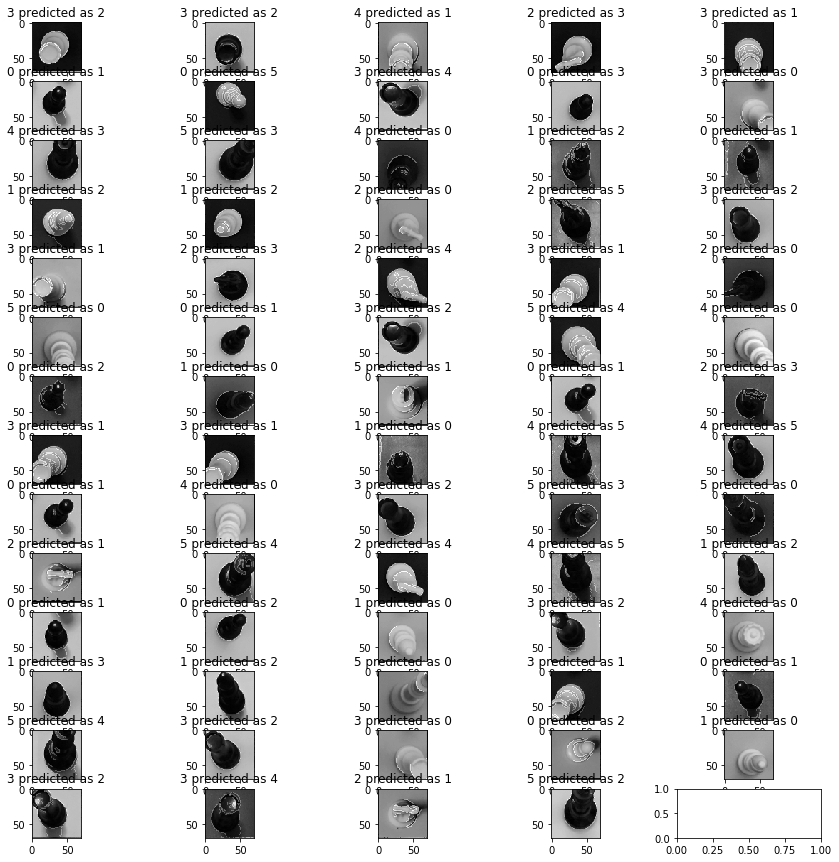

In [56]:
test_images = np.squeeze(X_test)
print(test_images.shape)
plot_mispredicted_images(test_images, y_test, y_test_pred)

## Make predictions on actual board images

Confusion matrix, without normalization
[[0 0 0 0 1 5]
 [0 0 1 0 0 1]
 [0 1 0 0 1 1]
 [2 0 0 0 0 1]
 [0 0 0 0 0 0]
 [1 0 0 0 1 0]]


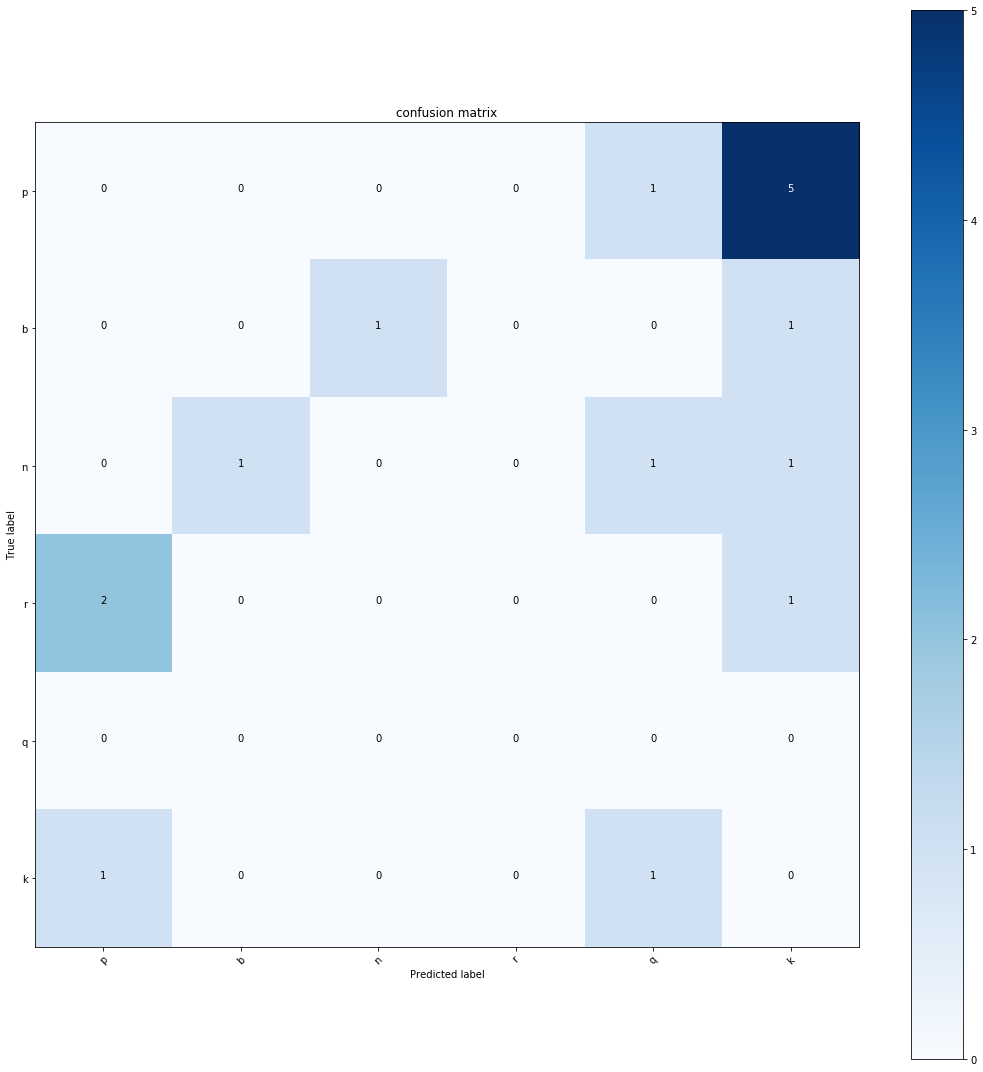

In [58]:
X_test1, y_test1 = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\actual_images_with_types")
test_predictions1 = model.predict(X_test1, batch_size=batch_size)
y_test_pred1 = [np.argmax(x) for x in test_predictions1]
cnf_matrix1 = confusion_matrix(y_test1, y_test_pred1)
plot_confusion_matrix(cnf_matrix1, classes=type_name_to_label, normalize=False,title='confusion matrix')